<a href="https://colab.research.google.com/github/DnYAlv/NLP_Final/blob/main/Notebook/4_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing
- This step is important since we want to have clean data for our model.

## Importing Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import zipfile
from google.colab import drive

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns


from wordcloud import WordCloud, STOPWORDS
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
all_stopwords = stopwords.words('english')
all_stopwords.remove('not') # To handle missconcept of sentiment

from nltk.stem.wordnet import WordNetLemmatizer
from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


In [2]:
# Unzipping files from drive
drive.mount('/content/drive/', force_remount=True)
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/NLP_Project/Dataset.zip', 'r')
zip_ref.extractall('/data_tmp')
zip_ref.close()

Mounted at /content/drive/


In [3]:
data_train = pd.read_csv('/data_tmp/Dataset/Corona_NLP_train.csv', encoding='latin-1')
data_test = pd.read_csv('/data_tmp/Dataset/Corona_NLP_test.csv', encoding='latin-1')

In [4]:
data_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
data_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


## Defining Features and Target Variables

- Based on our analysis previously, seems like we only need 'OriginalTweet' as our input data since this case mostly in Text data area.

In [6]:
data_train = data_train[['OriginalTweet', 'Sentiment']]
data_test = data_test[['OriginalTweet', 'Sentiment']]

## Word Cleaning

In [7]:
def clean_text(data):
    list_text = []
    for i in range(len(data)):

        # Remove URLs
        text1= re.sub(r'http\S+', ' ', data['OriginalTweet'][i])

        # Remove HTML tag
        text2 = re.sub(r'<.*?>',' ', text1) 

        # Remove Numbers
        text3 = re.sub(r'\d+',' ', text2)

        # Remove Hashtags
        text4 = re.sub(r'#\w+',' ', text3)

        # Tokenizing 
        final_text = re.sub('[^a-zA-Z]', ' ', text4)
        final_text = final_text.lower()
        final_text = final_text.split()

        # Lemmatizing and remove Stopwords
        lemma = WordNetLemmatizer()
        final_text = [lemma.lemmatize(word) for word in final_text if word not in all_stopwords]
        final_text = ' '.join(final_text)
        list_text.append(final_text)

    return list_text  

In [8]:
# Cleaning data
clean_data_train  = clean_text(data_train)
data_train.insert(1, 'clean_text', clean_data_train)

clean_data_test = clean_text(data_test)
data_test.insert(1, 'clean_text', clean_data_test)

In [9]:
data_train.head()

,OriginalTweet,clean_text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,menyrbie phil gahan chrisitv,Neutral
1,advice Talk to your neighbours family to excha...,advice talk neighbour family exchange phone nu...,Positive
2,Coronavirus Australia: Woolworths to give elde...,coronavirus australia woolworth give elderly d...,Positive
3,My food stock is not the only one which is emp...,food stock not one empty please panic enough f...,Positive
4,"Me, ready to go at supermarket during the #COV...",ready go supermarket outbreak not paranoid foo...,Extremely Negative


In [10]:
data_test.head()

,OriginalTweet,clean_text,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,trending new yorkers encounter empty supermark...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,find hand sanitizer fred meyer turned pack pur...,Positive
2,Find out how you can protect yourself and love...,find protect loved one,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,buying hit city anxious shopper stock food amp...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,news newsmelb one week everyone buying baby mi...,Neutral


## Sentiment Labelling

- We would like to change Extremely Positive to Positive, as well as Negative. (0,1,2)

In [11]:
data_train['Sentiment'] = data_train['Sentiment'].map({
    'Extremely Negative': 0,
    'Negative': 0,
    'Neutral' : 1,
    'Extremely Positive': 2,
    'Positive': 2
})
data_test['Sentiment'] = data_test['Sentiment'].map({
    'Extremely Negative': 0,
    'Negative': 0,
    'Neutral' : 1,
    'Extremely Positive': 2,
    'Positive': 2
})

In [12]:
data_train['Sentiment'].value_counts()

2    18046
0    15398
1     7713
Name: Sentiment, dtype: int64

In [13]:
data_test['Sentiment'].value_counts()

0    1633
2    1546
1     619
Name: Sentiment, dtype: int64

## Checking Missing Values

- We will try to filter words that have low length.

In [14]:
def check_length(data):
  string_length = []
  for word in data['clean_text']:
    length = len(word)
    string_length.append(length)
  
  return string_length

In [15]:
data_train['length'] = check_length(data_train)
data_test['length'] = check_length(data_test)

### Filtering sentence length

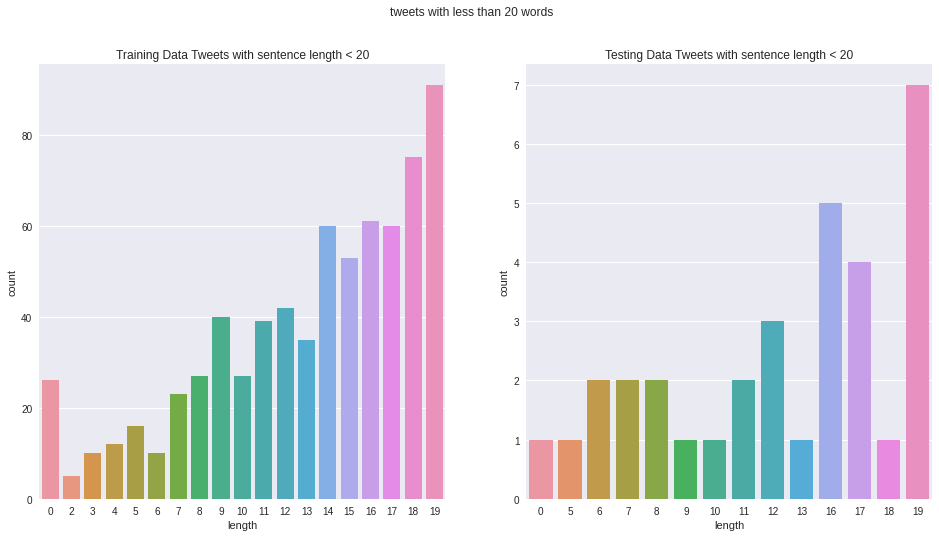

In [16]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
sns.countplot(x='length', data=data_train[data_train['length'] < 20], ax=ax[0])
ax[0].set_title('Training Data Tweets with sentence length < 20')

sns.countplot(x='length', data=data_test[data_test['length'] < 20], ax=ax[1])
ax[1].set_title('Testing Data Tweets with sentence length < 20')

plt.suptitle('tweets with less than 20 words')
plt.show()

> As we can see, there are still missing text (length = 0), let's try removing text that have length < 5.

In [17]:
data_train = data_train[data_train['length'] > 5]
data_test = data_test[data_test['length'] > 5]

# Exporting to CSV

In [18]:
data_train.to_csv('train_cleaned.csv', index=False)
data_test.to_csv('unseen_cleaned.csv', index=False)